In [1]:
import pandas as pd
from prettypandas import PrettyPandas
import numpy as np

from graphviz import Digraph
import seaborn as sns

import dexpy.factorial
import dexpy.alias
import dexpy.power

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import patches

from IPython.display import display, Markdown, HTML

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# dexpy/Design-Expert history

* Initial release 1985, written in Pascal
* Moved to C++ in 1996
* Used Python for some prototyping/validation, but mostly R
* Started using Python with Boost::Python in 2015 for testing components
* Moved to build system to waf (Python) from CMake (DSL)
* Created dexpy in 2016 based on the Design-Expert testing library

# Design of Experiments

A systematic series of tests, in which purposeful changes are made to input factors, so that you may identify causes for significant changes in the output repsonses.

  * Developed by Ronald Fisher in the 20s
  * "The Design of Experiments" introduced null hypothesis
  * Lady Tasting Tea experiment; milk or tea poured into cup first?
    * 8 cups prepared, 4 tasted: 70 permutations, 1.6% chance of random success

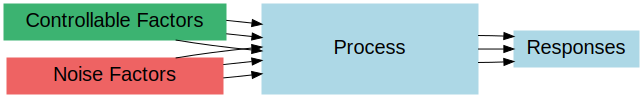

In [2]:
dot = Digraph(comment='Design of Experiments')
dot.body.extend(['rankdir=LR', 'size="10,10"'])
dot.node_attr.update(shape='rectangle', style='filled', fontsize='20', fontname="helvetica")

dot.node('X', 'Controllable Factors', color='mediumseagreen', width='3')
dot.node('Z', 'Noise Factors', color='indianred2', width='3')
dot.node('P', 'Process', color='lightblue', height='1.25', width='3')
dot.node('Y', 'Responses', color='lightblue')

dot.edges(['XP', 'ZP', 'PY'] * 3)

dot

# Traditional Experimentation

* One factor at a time
* Cannot detect interactions
* Inefficient

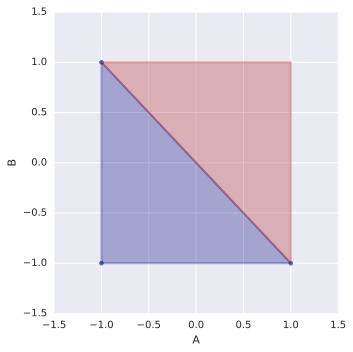

In [3]:
points = [
    [-1, -1],
    [-1, 1],
    [1, -1],
    [-1, -1],
    [-1, 1],
    [1, -1],
]
df = pd.DataFrame(points, columns=['A', 'B'])
fg = sns.lmplot('A', 'B', data=df, fit_reg=False)

p = patches.Polygon(points, color="navy", alpha=0.3, lw=2)
fg.axes[0, 0].add_patch(p)

p = patches.Polygon([[-1, 1], [1, 1], [1, -1]], color="firebrick", alpha=0.3, lw=2)
p = fg.axes[0, 0].add_patch(p)


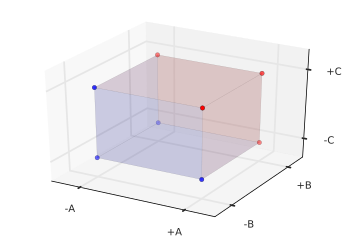

In [4]:
design = dexpy.factorial.build_factorial(4, 8)

points = np.array(design)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d', axisbg='w')
ax.view_init(30, -60) # rotate plot

X, Y = np.meshgrid([-1,1], [-1,1])

cube_alpha = 0.1
ax.plot_surface(X, Y, 1, alpha=cube_alpha, color="r")
ax.plot_surface(X, Y, -1, alpha=cube_alpha)
ax.plot_surface(X, -1, Y, alpha=cube_alpha)
ax.plot_surface(X, 1, Y, alpha=cube_alpha, color="r")
ax.plot_surface(1, X, Y, alpha=cube_alpha, color="r")
ax.plot_surface(-1, X, Y, alpha=cube_alpha)
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2],
             c=["b", "b", "b", "r", "b", "r", "r", "r"])

ax.set_xticks([-1, 1])
ax.set_xticklabels(["-A", "+A"])
ax.set_yticks([-1, 1])
ax.set_yticklabels(["-B", "+B"])
ax.set_zticks([-1, 1])
ax.set_zticklabels(["-C", "+C"])

plt.show()

# Factorial Design

* Multifactor testing
* Reveals interactions
* Maximizes information with minimum runs

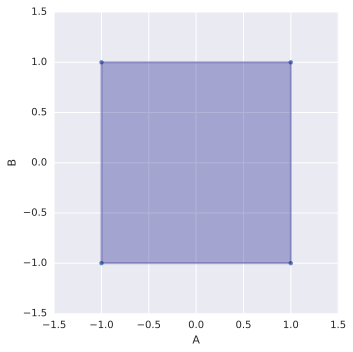

In [5]:
df = dexpy.factorial.build_factorial(2, 4)

fg = sns.lmplot('A', 'B', data=df, fit_reg=False)
p = fg.axes[0, 0].add_patch(patches.Rectangle((-1, -1), 2, 2, color="navy", alpha=0.3, lw=2))

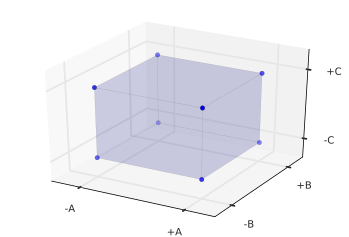

In [6]:
design = dexpy.factorial.build_factorial(4, 8)

points = np.array(design)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d', axisbg='w')
ax.view_init(30, -60) # rotate plot

X, Y = np.meshgrid([-1,1], [-1,1])

cube_alpha = 0.1
ax.plot_surface(X, Y, 1, alpha=cube_alpha)
ax.plot_surface(X, Y, -1, alpha=cube_alpha)
ax.plot_surface(X, -1, Y, alpha=cube_alpha)
ax.plot_surface(X, 1, Y, alpha=cube_alpha)
ax.plot_surface(1, X, Y, alpha=cube_alpha)
ax.plot_surface(-1, X, Y, alpha=cube_alpha)
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], c="b")

ax.set_xticks([-1, 1])
ax.set_xticklabels(["-A", "+A"])
ax.set_yticks([-1, 1])
ax.set_yticklabels(["-B", "+B"])
ax.set_zticks([-1, 1])
ax.set_zticklabels(["-C", "+C"])

plt.show()

# Statistical Power

The probability that a design will detect an active effect.

| Effect?       | Retain H<sub>0</sub>   | Reject H<sub>0</sub>    |
| ------------- |:-----------------------| -----------------------:|
| **No**        | OK                     | Type 1 Error            |
| **Yes**       | Type II Error          | OK                      |

Power is expressed as a probability to detect an effect of size Δ, given noise σ. This is typically given as a delta to sigma ratio Δ/σ. Power is a function of the signal to noise ratio, as well as the number and layout of experiments in the design.

50 runs, shift of 0.5 units


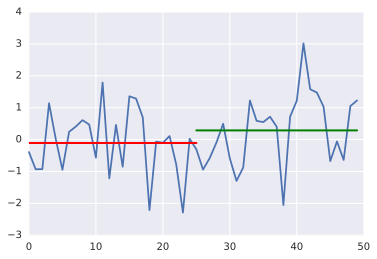

In [7]:
def plot_shift(runs, delta, sigma):
    low = sigma*np.random.randn(int(runs/2),1)
    high = sigma*np.random.randn(int(runs/2),1)+delta
    plt.plot(np.concatenate([low, high]))
    plt.plot([0, (runs/2)], [low.mean()] * 2, color='r', lw=2)
    plt.plot([(runs/2), runs-1], [high.mean()] * 2, color='g', lw=2)
    plt.show()

runs = 50
delta = 0.5
sigma = 1.0
print("{} runs, shift of {} units".format(runs, delta))
plot_shift(runs, delta, sigma)

shift of 2.0 units (increase in signal)


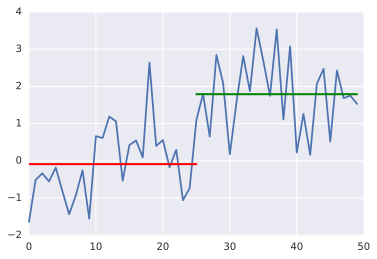

In [8]:
print("shift of {} units (increase in signal)".format(delta*4))
plot_shift(runs, delta*4, sigma)

sigma 0.1, shift of 0.5 units (decrease in noise)


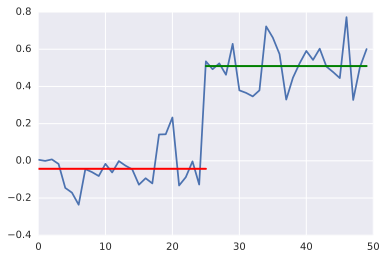

In [9]:
print("sigma {}, shift of {} units (decrease in noise)".format(sigma*0.1, delta))
plot_shift(runs, delta, sigma*0.1)

500 runs, shift of 0.5 units (increase in experiments)


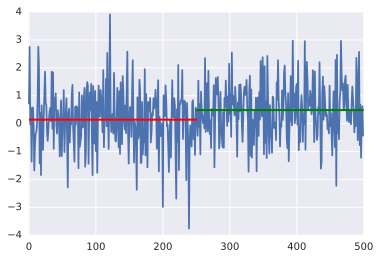

In [10]:
print("{} runs, shift of {} units (increase in experiments)".format(runs*10, delta))
plot_shift(runs*10, delta, sigma)

In [33]:
ofat_points = [
    [-1, -1, -1],
    [-1, -1, -1],
    [1, -1, -1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
    [-1, -1, 1],
]

sn = 2.0
alpha = 0.05

ofat_df = pd.DataFrame(ofat_points, columns=['A', 'B', 'C'])
ofat_power = dexpy.power.f_power("1 + A + B + C", ofat_df, sn, alpha)
ofat_power.pop(0) # remove intercept
ofat_power = ['{0:.2f}%'.format(i*100) for i in ofat_power] # convert to %
ofat_power = pd.DataFrame(ofat_power, columns=['Power'], index=ofat_df.columns)

display(Markdown("# OFAT Power:"))
display(PrettyPandas(ofat_power))

design = dexpy.factorial.build_factorial(3, 8)
factorial_power = dexpy.power.f_power("1 + A + B + C", design, sn, alpha)
factorial_power.pop(0)
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # convert to %
factorial_power = pd.DataFrame(factorial_power, columns=['Power'], index=design.columns)

display(Markdown("# Factorial Power:"))
display(PrettyPandas(factorial_power))


# OFAT Power:

# Factorial Power: